# Install Modules

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install imblearn
!pip install xgboost
!pip install tensorflow

# Import Dependencies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import seaborn as sns
import sklearn
import imblearn
import matplotlib.pyplot as plt
import time
import os
import sklearn.metrics as m
import xgboost as xgbxgboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.client import device_lib
import logging
import warnings

# Setup Stuff

In [2]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [3]:
get_available_gpus()

[]

In [4]:

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
logging.getLogger("tensorflow").setLevel(logging.WARNING)
#Settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')


# Prepare the Dataset File

### Join the Dataset parts

In [ ]:
def prepare_base_dataset_file(__data_folder, __force_overwrite = False):
    """
    This function prepares the dataset file for the training and testing of the models.
    """

    # the dataset folder
    _data_csv_folder = os.path.join(__data_folder, 'MachineLearningCSV', 'MachineLearningCVE')

    # the list of files to be joined
    _data_files = []
    _data_files.append(os.path.join(_data_csv_folder, 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'))
    _data_files.append(os.path.join(_data_csv_folder, 'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv'))
    _data_files.append(os.path.join(_data_csv_folder, 'Friday-WorkingHours-Morning.pcap_ISCX.csv'))
    _data_files.append(os.path.join(_data_csv_folder, 'Monday-WorkingHours.pcap_ISCX.csv'))
    _data_files.append(os.path.join(_data_csv_folder, 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv'))
    _data_files.append(os.path.join(_data_csv_folder, 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv'))
    _data_files.append(os.path.join(_data_csv_folder, 'Tuesday-WorkingHours.pcap_ISCX.csv'))
    _data_files.append(os.path.join(_data_csv_folder, 'Wednesday-workingHours.pcap_ISCX.csv'))

    # the final dataset file
    _final_dataset_path = os.path.join(__data_folder, "dataset_base.csv")

    # check if the dataset folder exists
    if not os.path.exists(_data_csv_folder):
        print('Data folder not found')
        return False

    # check if the dataset files exist
    if os.path.exists(_final_dataset_path) and not __force_overwrite:
        print('Joined dataset already exists')
        return False

    # load and join the dataset files
    _temp = None
    _data = pd.read_csv(_data_files[0])
    print(f'Loaded {_data_files[0]}')
    for file in _data_files[1:]:
        _temp = pd.read_csv(file)
        _data = pd.concat([_data, _temp])
        print(f'Loaded {file}')
    del _temp

    # preprocess the dataset
    print("Preprocessing the dataset ...", end = ' ')
    _data[['Flow Bytes/s', ' Flow Packets/s']] = _data[['Flow Bytes/s', ' Flow Packets/s']].apply(pd.to_numeric)
    print("Done")

    # drop the useless stuff
    print("Dropping useless columns ...", end = ' ')
    _data.drop([' Bwd PSH Flags'], axis=1, inplace=True)
    _data.drop([' Bwd URG Flags'], axis=1, inplace=True)
    _data.drop(['Fwd Avg Bytes/Bulk'], axis=1, inplace=True)
    _data.drop([' Fwd Avg Packets/Bulk'], axis=1, inplace=True)
    _data.drop([' Fwd Avg Bulk Rate'], axis=1, inplace=True)
    _data.drop([' Bwd Avg Bytes/Bulk'], axis=1, inplace=True)
    _data.drop([' Bwd Avg Packets/Bulk'], axis=1, inplace=True)
    _data.drop(['Bwd Avg Bulk Rate'], axis=1, inplace=True)
    print("Done")

    # drop the rows with NaN, inf, -inf values
    print("Dropping rows with NaN, inf, -inf values ...", end = ' ')
    _data.replace([np.inf, -np.inf], np.nan, inplace=True)
    _data.dropna(axis="index", how="any", inplace=True)
    print("Done")

    # write the final dataset to file
    print("Writing Joined Dataset to file ...", end = ' ')
    _data.to_csv(_final_dataset_path, index=False)
    print("Done")

    # delete the temporary variables
    del _data

    return True

In [ ]:
prepare_base_dataset_file('dataset', True)

Loaded dataset\MachineLearningCSV\MachineLearningCVE\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Loaded dataset\MachineLearningCSV\MachineLearningCVE\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Loaded dataset\MachineLearningCSV\MachineLearningCVE\Friday-WorkingHours-Morning.pcap_ISCX.csv
Loaded dataset\MachineLearningCSV\MachineLearningCVE\Monday-WorkingHours.pcap_ISCX.csv
Loaded dataset\MachineLearningCSV\MachineLearningCVE\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Loaded dataset\MachineLearningCSV\MachineLearningCVE\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Loaded dataset\MachineLearningCSV\MachineLearningCVE\Tuesday-WorkingHours.pcap_ISCX.csv
Loaded dataset\MachineLearningCSV\MachineLearningCVE\Wednesday-workingHours.pcap_ISCX.csv
Preprocessing the dataset ... Done
Dropping useless columns ... Done
Dropping rows with NaN, inf, -inf values ... Done
Writing Joined Dataset to file ... Done


True

### Preprocess the Dataset

In [ ]:
def load_and_preprocess_base_dataset(__data_folder, __force_overwrite = False):
    _source_dataset_path = os.path.join(__data_folder, "dataset_base.csv")
    _final_dataset_path = os.path.join(__data_folder, "dataset_preprocessed.csv")

    # check if the dataset exists
    if not os.path.exists(_source_dataset_path):
        print('Base Dataset not found')
        return False

    # check if the dataset files exist
    if os.path.exists(_final_dataset_path) and not __force_overwrite:
        print('Preprocessed dataset already exists')
        return False
    
    # load the dataset
    print("Loading the base dataset ...", end = ' ')
    _data = pd.read_csv(_source_dataset_path)
    print("Done")

    _scalar = StandardScaler()
    _cols = _data.select_dtypes(include=['float64', 'int64']).columns

    # preprocess the dataset
    print("Preprocessing the dataset ...", end = ' ')
    _fit_data = _scalar.fit_transform(_data.select_dtypes(include=['float64', 'int64']))
    print("Done")

    
    # create the final dataset
    print("Creating the final dataset ...", end = ' ')
    _data_preprocessed = pd.DataFrame(_fit_data, columns=_cols)
    _data_preprocessed[' Label'] = _data[' Label']
    print("Done")

    # write the final dataset to file
    print("Writing Preprocessed Dataset to file ...", end = ' ')
    _data_preprocessed.to_csv(_final_dataset_path, index=False)
    print("Done")

    del _data
    del _fit_data
    del _data_preprocessed

    return True

In [ ]:
load_and_preprocess_base_dataset('dataset', True)

Loading the base dataset ... Done
Preprocessing the dataset ... Done
Creating the final dataset ... Done
Writing Preprocessed Dataset to file ... Done


True

### Use SMOTE to balance the Dataset

In [ ]:
dataset = pd.read_csv('dataset/dataset_preprocessed.csv')

In [ ]:
dataset.value_counts(' Label')

 Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

Here we drop the biggest class BENIGN

In [ ]:
dataset.drop(dataset[dataset[' Label'] == 'BENIGN'].index, inplace=True)

In [ ]:
dataset.value_counts(' Label')

 Label
DoS Hulk                      230124
PortScan                      158804
DDoS                          128025
DoS GoldenEye                  10293
FTP-Patator                     7935
SSH-Patator                     5897
DoS slowloris                   5796
DoS Slowhttptest                5499
Bot                             1956
Web Attack � Brute Force        1507
Web Attack � XSS                 652
Infiltration                      36
Web Attack � Sql Injection        21
Heartbleed                        11
Name: count, dtype: int64

In [ ]:
smote_sampler = SMOTE(random_state=42)

In [ ]:
X = dataset.drop([' Label'], axis=1)
y = dataset[' Label']

In [ ]:
X, y = smote_sampler.fit_resample(X.to_numpy(), y.to_numpy())

In [ ]:
X_cols = dataset.drop([' Label'], axis=1).columns
y_cols = [' Label']
X = pd.DataFrame(X, columns=X_cols)
y = pd.DataFrame(y, columns=y_cols)

In [ ]:
new_dataset = pd.concat([X, y], axis=1)

Reload the original dataset to merge with generated one

In [ ]:
dataset = pd.read_csv('dataset/dataset_preprocessed.csv')

In [ ]:
dataset = pd.concat([dataset, new_dataset])

In [ ]:
dataset.value_counts(' Label')

 Label
BENIGN                        2271320
DoS Hulk                       460248
PortScan                       388928
DDoS                           358149
DoS GoldenEye                  240417
FTP-Patator                    238059
SSH-Patator                    236021
DoS slowloris                  235920
DoS Slowhttptest               235623
Bot                            232080
Web Attack � Brute Force       231631
Web Attack � XSS               230776
Infiltration                   230160
Web Attack � Sql Injection     230145
Heartbleed                     230135
Name: count, dtype: int64

In [ ]:
dataset.to_csv('dataset/dataset_preprocessed_smote.csv', index=False)

Cleanup and Free Memory

In [ ]:
del dataset
del X
del y
del smote_sampler
del new_dataset

# The Dataset Class

In [5]:
class Cicids2017Dataset:
    
    def __init__(self, __data_folder):
        self._data_folder = __data_folder
        self._data = None
        self._labels = None
        self._train_data = None
        self._test_data = None
        self._train_labels = None
        self._test_labels = None
        self._label_index_to_name = None

    def _load_dataset(self, __dataset_path):
        if not os.path.exists(__dataset_path):
            print('Dataset file not found')
            return False
        self._data = pd.read_csv(__dataset_path)
        self._labels = self._data[' Label'].unique()
        return True

    def load_base_dataset(self):
        return self._load_dataset(os.path.join(self._data_folder, "dataset_base.csv"))
    
    def load_preprocessed_dataset(self):
        return self._load_dataset(os.path.join(self._data_folder, "dataset_preprocessed.csv"))
    
    def load_preprocessed_smote_dataset(self):
        return self._load_dataset(os.path.join(self._data_folder, "dataset_preprocessed_smote.csv"))

    def _transform_labels_to_one_hot(self):
        if self._train_labels is None or self._test_labels is None:
            return
        self._train_labels = pd.get_dummies(self._train_labels).astype('float64')
        self._test_labels = pd.get_dummies(self._test_labels).astype('float64')
        self._label_index_to_name = self._train_labels.columns

    def prepare_train_test_data(self, __test_size = 0.1, __random_state = 42):
        self._train_data, self._test_data = train_test_split(self._data, test_size=__test_size, random_state=__random_state)
        self._train_labels = self._train_data[' Label']
        self._test_labels = self._test_data[' Label']
        self._transform_labels_to_one_hot()        
        self._train_data.drop([' Label'], axis=1, inplace=True)
        self._test_data.drop([' Label'], axis=1, inplace=True)

    def free_internal_memory(self):
        del self._data
        self._data = None

    def get_labels(self):
        return self._labels

    def drop_label(self, label_to_drop):
        if not self._has_loaded:
            return
        self._data = self._data[self._data[" Label"] != label_to_drop]

In [6]:
dataset = Cicids2017Dataset('dataset')

# Tensorflow Model for Prediction

### Build the model

In [7]:
def create_tf_model_v0(__input_count, __output_count):
    _model = keras.Sequential([
        layers.Input(__input_count),
        layers.Dense(128, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(__output_count, activation='softmax')
    ])

    _model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return _model

### Prepare the data

In [ ]:
# dataset.load_preprocessed_smote_dataset()
dataset.load_preprocessed_dataset()

True

In [ ]:
dataset._data.head()

Destination Port   Flow Duration   Total Fwd Packets  \
0           2.561161       -0.439612           -0.009825   
1           2.571503       -0.439609           -0.011158   
2           2.571558       -0.439611           -0.011158   
3           2.088968       -0.439612           -0.011158   
4           2.561052       -0.439612           -0.009825   

    Total Backward Packets  Total Length of Fwd Packets  \
0                -0.010426                    -0.053793   
1                -0.009424                    -0.054393   
2                -0.009424                    -0.054393   
3                -0.009424                    -0.054393   
4                -0.010426                    -0.053793   

    Total Length of Bwd Packets   Fwd Packet Length Max  \
0                     -0.007145               -0.281253   
1                     -0.007143               -0.281253   
2                     -0.007143               -0.281253   
3                     -0.007143               -0.281253   
4                     -0.007145               -0.281253   

    Fwd Packet Length Min   Fwd Packet Length Mean   Fwd Packet Length Std  \
0               -0.210906                -0.280686               -0.245193   
1               -0.210906                -0.280686               -0.245193   
2               -0.210906                -0.280686               -0.245193   
3               -0.210906                -0.280686               -0.245193   
4               -0.210906                -0.280686               -0.245193   

   ...   min_seg_size_forward  Active Mean   Active Std   Active Max  \
0  ...               0.002547    -0.125799    -0.104619    -0.149404   
1  ...               0.002547    -0.125799    -0.104619    -0.149404   
2  ...               0.002547    -0.125799    -0.104619    -0.149404   
3  ...               0.002547    -0.125799    -0.104619    -0.149404   
4  ...               0.002547    -0.125799    -0.104619    -0.149404   

    Active Min  Idle Mean   Idle Std   Idle Max   Idle Min   Label  
0    -0.101068  -0.352126  -0.109516  -0.357072  -0.339184  BENIGN  
1    -0.101068  -0.352126  -0.109516  -0.357072  -0.339184  BENIGN  
2    -0.101068  -0.352126  -0.109516  -0.357072  -0.339184  BENIGN  
3    -0.101068  -0.352126  -0.109516  -0.357072  -0.339184  BENIGN  
4    -0.101068  -0.352126  -0.109516  -0.357072  -0.339184  BENIGN  

[5 rows x 71 columns]

In [ ]:
dataset.prepare_train_test_data()

In [ ]:
dataset._train_labels.head()

BENIGN  Bot  DDoS  DoS GoldenEye  DoS Hulk  DoS Slowhttptest  \
1232197     1.0  0.0   0.0            0.0       0.0               0.0   
4627156     0.0  0.0   0.0            0.0       0.0               0.0   
3346887     0.0  0.0   0.0            0.0       1.0               0.0   
4795634     0.0  0.0   0.0            0.0       0.0               0.0   
4636366     0.0  0.0   0.0            0.0       0.0               0.0   

         DoS slowloris  FTP-Patator  Heartbleed  Infiltration  PortScan  \
1232197            0.0          0.0         0.0           0.0       0.0   
4627156            0.0          0.0         1.0           0.0       0.0   
3346887            0.0          0.0         0.0           0.0       0.0   
4795634            0.0          0.0         1.0           0.0       0.0   
4636366            0.0          0.0         1.0           0.0       0.0   

         SSH-Patator  Web Attack � Brute Force  Web Attack � Sql Injection  \
1232197          0.0                       0.0                         0.0   
4627156          0.0                       0.0                         0.0   
3346887          0.0                       0.0                         0.0   
4795634          0.0                       0.0                         0.0   
4636366          0.0                       0.0                         0.0   

         Web Attack � XSS  
1232197               0.0  
4627156               0.0  
3346887               0.0  
4795634               0.0  
4636366               0.0

### Instantiate the model and Train

In [ ]:
tf_model_v0 = create_tf_model_v0(70, 15)

In [ ]:
tf_model_v0.fit(dataset._train_data.to_numpy(), dataset._train_labels.to_numpy(), batch_size=1024, epochs=5)

Epoch 1/5
5318/5318 [==============================] - 31s 6ms/step - loss: 0.1028 - accuracy: 0.9529
Epoch 2/5
5318/5318 [==============================] - 27s 5ms/step - loss: 0.1025 - accuracy: 0.9522
Epoch 3/5
5318/5318 [==============================] - 31s 6ms/step - loss: 0.1023 - accuracy: 0.9521
Epoch 4/5
5318/5318 [==============================] - 27s 5ms/step - loss: 0.1012 - accuracy: 0.9527
Epoch 5/5
5318/5318 [==============================] - 26s 5ms/step - loss: 0.1003 - accuracy: 0.9528


In [ ]:
tf_model_v0.evaluate(dataset._test_data.to_numpy(), dataset._test_labels.to_numpy())

18906/18906 [==============================] - 15s 777us/step - loss: 0.0958 - accuracy: 0.9545


[0.09583732485771179, 0.9545062184333801]

### Calculate the individual sucess scores

In [ ]:
_logits_on_test_data = tf_model_v0.predict(dataset._test_data.to_numpy())

18906/18906 [==============================] - 14s 716us/step


In [ ]:
_predictions_on_test_data = np.argmax(_logits_on_test_data, axis=1)
_labels_on_test_data = dataset._test_labels.to_numpy().argmax(axis=1)

In [ ]:
_labels = dataset.get_labels()
_class_based_accuracies = []
for _i in range(len(_labels)):
    _positive_cases = np.count_nonzero((_predictions_on_test_data == _i) & (_labels_on_test_data == _i))
    _total_cases = np.count_nonzero(_labels_on_test_data == _i)
    _class_based_accuracies.append((dataset._label_index_to_name[_i], _positive_cases, _total_cases, _positive_cases / _total_cases))
_class_based_accuracies = pd.DataFrame(_class_based_accuracies, columns=['Label', 'Positive Cases', 'Total Cases', 'Accuracy'])

In [ ]:
_class_based_accuracies

Label  Positive Cases  Total Cases  Accuracy
0                       BENIGN          224038       226840  0.987648
1                          Bot           22418        23102  0.970392
2                         DDoS           36012        36019  0.999806
3                DoS GoldenEye           23863        23896  0.998619
4                     DoS Hulk           45833        45910  0.998323
5             DoS Slowhttptest           23608        23686  0.996707
6                DoS slowloris           23202        23370  0.992811
7                  FTP-Patator           23640        23701  0.997426
8                   Heartbleed           23205        23205  1.000000
9                 Infiltration           23143        23152  0.999611
10                    PortScan           39297        39320  0.999415
11                 SSH-Patator           23148        23765  0.974037
12    Web Attack � Brute Force           10936        23178  0.471827
13  Web Attack � Sql Injection           16212        22809  0.710772
14            Web Attack � XSS           18885        23009  0.820766

### Prepare Confusion Matrix

In [ ]:
_confusion_matrix = tf.math.confusion_matrix(labels=_labels_on_test_data, predictions=_predictions_on_test_data).numpy()

<Axes: >

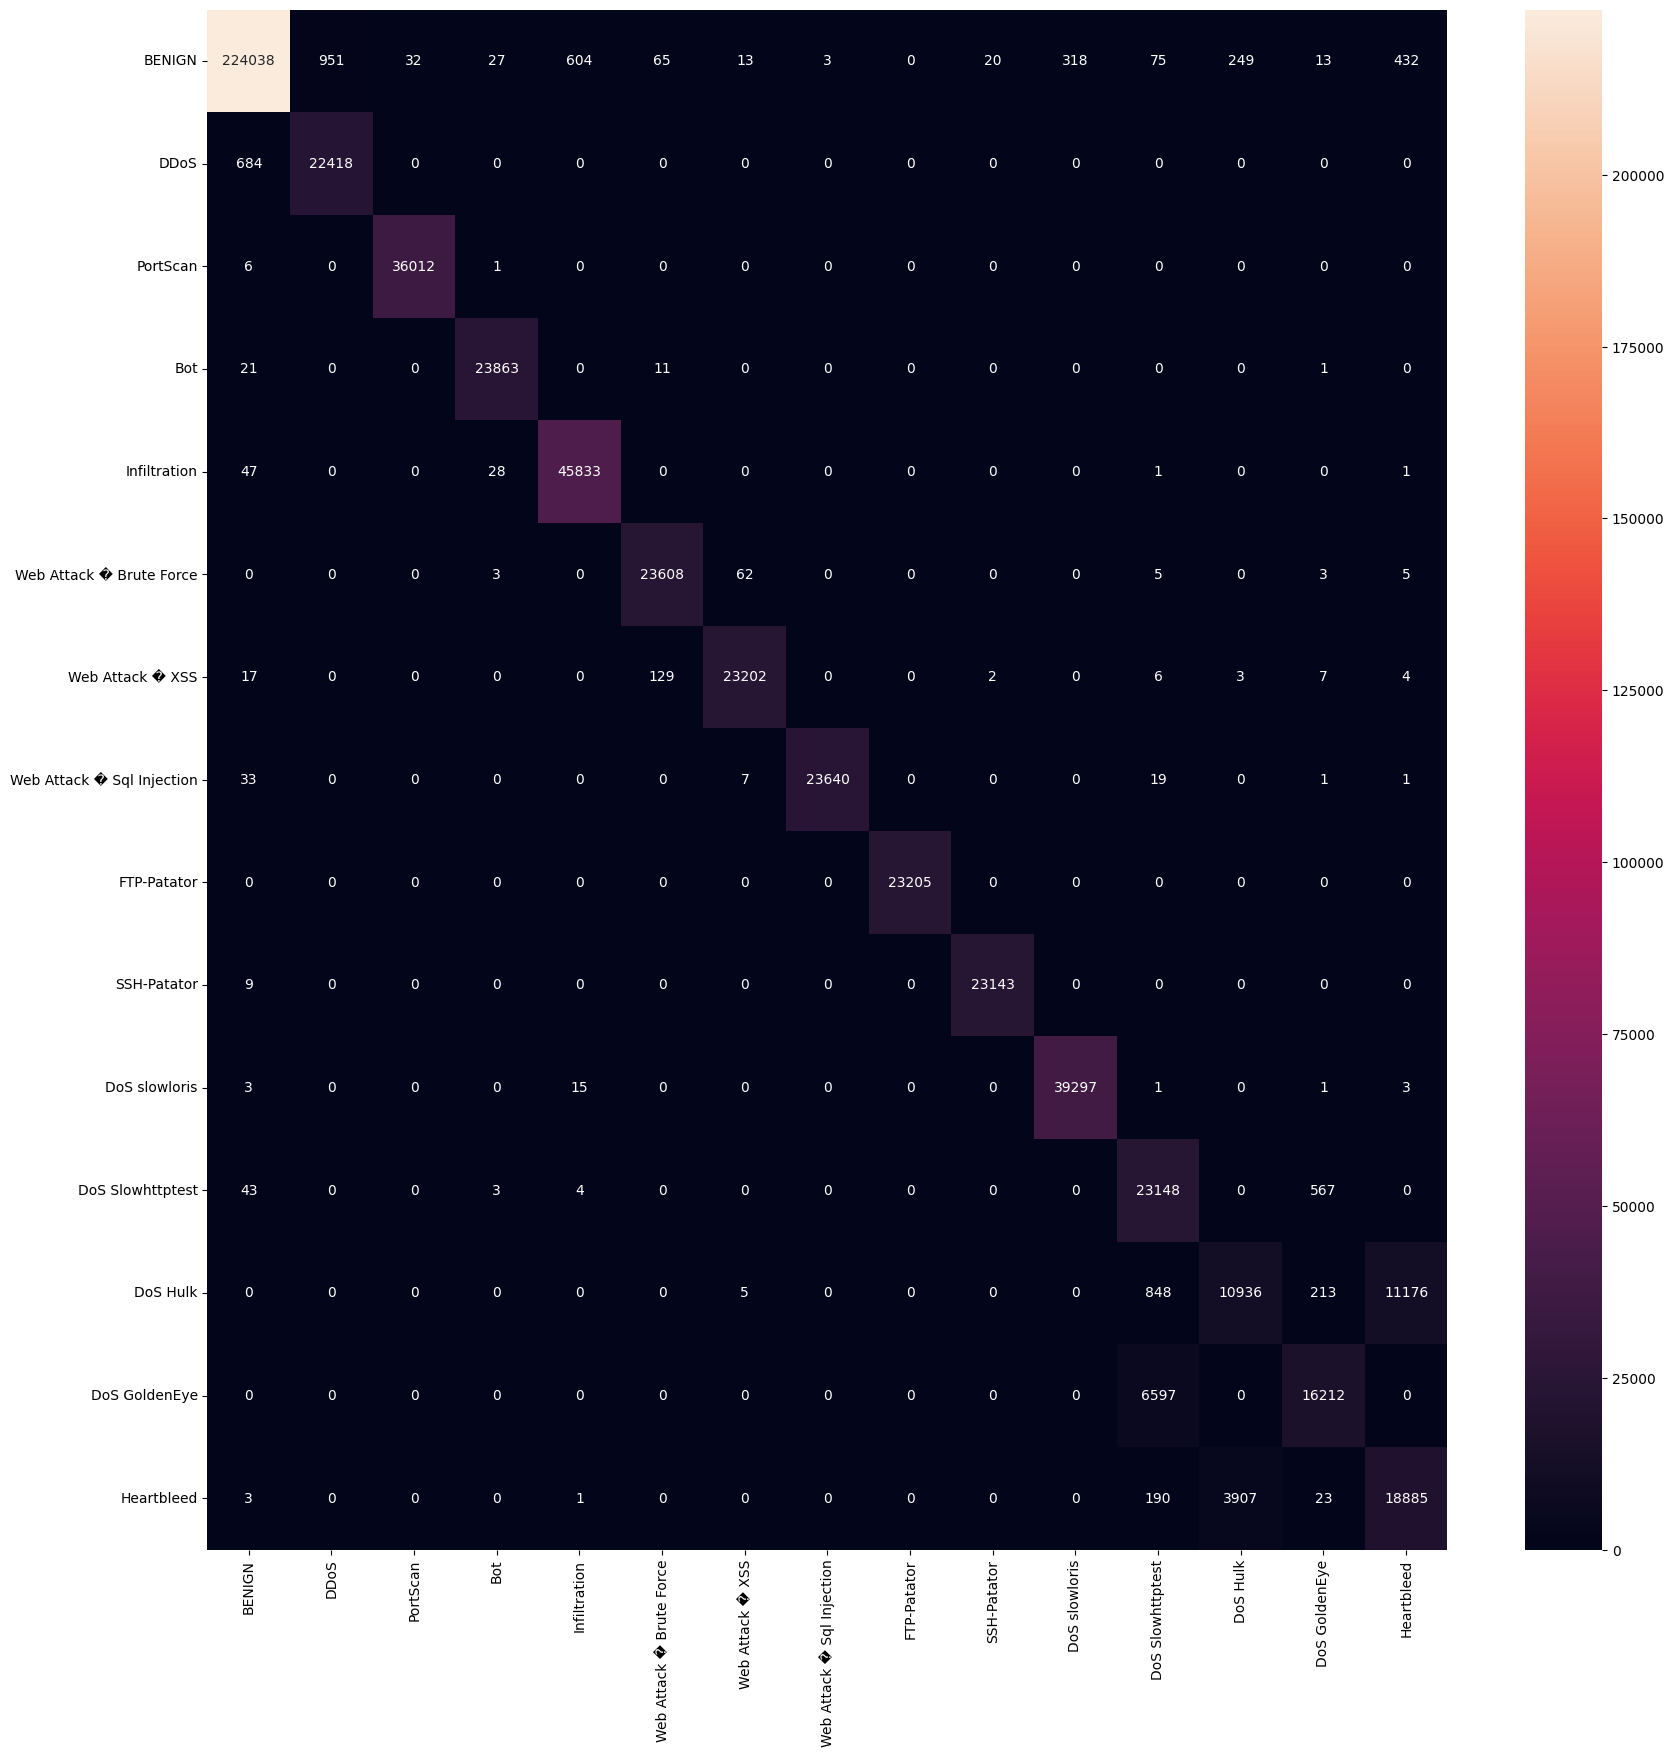

In [ ]:
plt.figure(figsize=(20, 20))
sns.heatmap(_confusion_matrix, annot=True, fmt='d', xticklabels=_labels, yticklabels=_labels)

In [ ]:
del _logits_on_test_data
del _predictions_on_test_data
del _labels_on_test_data

### Train for Binary Classification

In [8]:
def prepare_binary_classification_taining_labels(__original_labels, __positive_label):
    _np_labels = __original_labels.argmax(axis=1)
    _arr0 = [np.array([1, 0]) if dataset._label_index_to_name[_i] == __positive_label else np.array([0, 1]) for _i in _np_labels]
    return np.stack(np.array(_arr0)).astype('float64')

In [ ]:
dataset.load_preprocessed_dataset()

In [12]:
dataset.prepare_train_test_data()

In [13]:
dataset._train_data.head()

Destination Port   Flow Duration   Total Fwd Packets  \
1232197          -0.438240       -0.439608           -0.009825   
4627156          -0.416844        1.996184            2.553048   
3346887          -0.436762        2.513976           -0.001825   
4795634          -0.416844        3.103412            3.715786   
4636366          -0.416844        3.103517            3.702869   

          Total Backward Packets  Total Length of Fwd Packets  \
1232197                -0.008422                    -0.046992   
4627156                 1.442986                     1.069287   
3346887                -0.005415                    -0.024889   
4795634                 2.045451                     1.262267   
4636366                 2.078010                     0.953819   

          Total Length of Bwd Packets   Fwd Packet Length Max  \
1232197                     -0.007082               -0.233868   
4627156                      2.386005                7.782654   
3346887                     -0.002025                0.121524   
4795634                      3.472603                7.028395   
4636366                      3.473816                2.730152   

          Fwd Packet Length Min   Fwd Packet Length Mean  \
1232197                0.352425                -0.098061   
4627156               -0.310317                -0.270232   
3346887               -0.310317                -0.110818   
4795634               -0.310317                -0.287621   
4636366               -0.310317                -0.293479   

          Fwd Packet Length Std  Bwd Packet Length Max  \
1232197               -0.245193              -0.410717   
4627156                0.326916               6.695752   
3346887                0.124549               2.526900   
4795634                0.110735               8.198147   
4636366               -0.090352               8.291527   

          Bwd Packet Length Min   Bwd Packet Length Mean  \
1232197                0.448755                -0.386892   
4627156               -0.596523                 5.673786   
3346887               -0.596523                 3.324180   
4795634               -0.596523                 5.838426   
4636366               -0.596523                 5.740438   

          Bwd Packet Length Std  Flow Bytes/s   Flow Packets/s  \
1232197               -0.399578     -0.001795        -0.177064   
4627156                2.415996     -0.054950        -0.278336   
3346887                2.485521     -0.057502        -0.278498   
4795634                2.538582     -0.054956        -0.278338   
4636366                2.449933     -0.054956        -0.278338   

          Flow IAT Mean   Flow IAT Std   Flow IAT Max   Flow IAT Min  \
1232197       -0.288182      -0.363026      -0.375626      -0.055066   
4627156       -0.282817      -0.344184      -0.334948      -0.055067   
3346887        1.549188       3.202443       3.682368      -0.055066   
4795634       -0.282737      -0.344045      -0.334941      -0.055067   
4636366       -0.282762      -0.343997      -0.334958      -0.055067   

         Fwd IAT Total   Fwd IAT Mean   Fwd IAT Std   Fwd IAT Max  \
1232197      -0.431610      -0.274164     -0.339121     -0.368873   
4627156       2.004870      -0.269712     -0.318429     -0.328263   
3346887       2.524657       1.215838      3.549558      3.677599   
4795634       3.111147      -0.269688     -0.318368     -0.328260   
4636366       3.111147      -0.269671     -0.318287     -0.328215   

          Fwd IAT Min  Bwd IAT Total   Bwd IAT Mean   Bwd IAT Std  \
1232197     -0.119004      -0.344489      -0.203296     -0.236804   
4627156     -0.119004       2.493969      -0.196992     -0.200523   
3346887     -0.119004      -0.339701      -0.199426     -0.226522   
4795634     -0.119004       3.794722      -0.196753     -0.199905   
4636366     -0.119004       3.794722      -0.196856     -0.200138   

          Bwd IAT Max   Bwd IAT Min  Fwd PSH Flags   Fwd URG Flags  \
1232197     -0.273134     -0.1

In [14]:
dataset._train_labels.value_counts()

BENIGN  Bot  DDoS  DoS GoldenEye  DoS Hulk  DoS Slowhttptest  DoS slowloris  FTP-Patator  Heartbleed  Infiltration  PortScan  SSH-Patator  Web Attack � Brute Force  Web Attack � Sql Injection  Web Attack � XSS
1.0     0.0  0.0   0.0            0.0       0.0               0.0            0.0          0.0         0.0           0.0       0.0          0.0                       0.0                         0.0                 2044480
0.0     0.0  0.0   0.0            1.0       0.0               0.0            0.0          0.0         0.0           0.0       0.0          0.0                       0.0                         0.0                  414338
                                  0.0       0.0               0.0            0.0          0.0         0.0           1.0       0.0          0.0                       0.0                         0.0                  349608
             1.0   0.0            0.0       0.0               0.0            0.0          0.0         0.0           0.0       0

In [15]:
_labels = dataset.get_labels()
_class_based_accuracies = []
for _i in range(len(_labels)):
    print(f"Label {_i} ({dataset._label_index_to_name[_i]})")
    _tf_model_v1 = create_tf_model_v0(70, 2)
    print("Training...")
    _train_y = prepare_binary_classification_taining_labels(dataset._train_labels.to_numpy(), dataset._label_index_to_name[_i])
    _tf_model_v1.fit(dataset._train_data.to_numpy(), _train_y, batch_size=1024, epochs=2)
    print("Evaluating...")
    _test_y = prepare_binary_classification_taining_labels(dataset._test_labels.to_numpy(), dataset._label_index_to_name[_i])
    # _loss_value, _acc_value = _tf_model_v1.evaluate(dataset._test_data.to_numpy(), _test_y)
    _predictions_on_test_data = _tf_model_v1.predict(dataset._test_data.to_numpy())
    _total_cases = dataset._test_data.shape[0]
    _actual_positive_cases = np.count_nonzero(_test_y.argmax(axis=1) == 0)
    _correct_predictions = np.count_nonzero(_predictions_on_test_data.argmax(axis=1) == _test_y.argmax(axis=1))
    _true_positive_cases = np.count_nonzero((_predictions_on_test_data.argmax(axis=1) == 0) & (_test_y.argmax(axis=1) == 0))
    _false_positive_cases = np.count_nonzero((_predictions_on_test_data.argmax(axis=1) == 0) & (_test_y.argmax(axis=1) == 1))
    _false_negative_cases = np.count_nonzero((_predictions_on_test_data.argmax(axis=1) == 1) & (_test_y.argmax(axis=1) == 0))
    _true_negative_cases = np.count_nonzero((_predictions_on_test_data.argmax(axis=1) == 1) & (_test_y.argmax(axis=1) == 1))
    _accuracy_value = _correct_predictions / _total_cases
    _precision_value = _true_positive_cases / (_true_positive_cases + _false_positive_cases)
    _recall_value = _true_positive_cases / (_true_positive_cases + _false_negative_cases)
    _f1_score_value = 2 * ( (_precision_value * _recall_value) / (_precision_value + _recall_value) )
    _class_based_accuracies.append([dataset._label_index_to_name[_i], _accuracy_value, _precision_value, _recall_value, _f1_score_value, _correct_predictions, _total_cases])
    print(f"Accuracy: {_accuracy_value}, Precision: {_precision_value}, Recall: {_recall_value}, F1 Score: {_f1_score_value}, Correct Predictions: {_correct_predictions}, Total Cases: {_total_cases}")
    print("--------------------------------------------------")
_class_based_accuracies = pd.DataFrame(_class_based_accuracies, columns=["Label", "Accuracy", "Precision", "Recall", "F1 Score", "Correct Predictions", "Total Cases"])

Label 0 (BENIGN)
Training...
Epoch 1/2
5318/5318 [==============================] - 24s 4ms/step - loss: 0.0589 - accuracy: 0.9779
Epoch 2/2
5318/5318 [==============================] - 23s 4ms/step - loss: 0.0435 - accuracy: 0.9840
Evaluating...
18906/18906 [==============================] - 12s 644us/step
Accuracy: 0.9695782545019357, Precision: 0.9453075595207575, Recall: 0.9752953623699524, F1 Score: 0.9600673500030377, Correct Predictions: 586558, Total Cases: 604962
--------------------------------------------------
Label 1 (Bot)
Training...
Epoch 1/2
5318/5318 [==============================] - 30s 5ms/step - loss: 0.0125 - accuracy: 0.9950
Epoch 2/2
5318/5318 [==============================] - 30s 6ms/step - loss: 0.0080 - accuracy: 0.9970
Evaluating...
18906/18906 [==============================] - 13s 662us/step
Accuracy: 0.9975419943732003, Precision: 0.9452111225540679, Recall: 0.9932040515972643, F1 Score: 0.9686134622285075, Correct Predictions: 603475, Total Cases: 60496

In [ ]:
_class_based_accuracies

Label  Accuracy  Actual Positive Cases  \
0                       BENIGN  0.985348                 226840   
1                          Bot  0.996256                  23102   
2                         DDoS  0.999843                  36019   
3                DoS GoldenEye  0.999526                  23896   
4                     DoS Hulk  0.997112                  45910   
5             DoS Slowhttptest  0.999326                  23686   
6                DoS slowloris  0.999473                  23370   
7                  FTP-Patator  0.999445                  23701   
8                   Heartbleed  1.000000                  23205   
9                 Infiltration  0.999671                  23152   
10                    PortScan  0.994636                  39320   
11                 SSH-Patator  0.985948                  23765   
12    Web Attack � Brute Force  0.972416                  23178   
13  Web Attack � Sql Injection  0.984920                  22809   
14            Web Attack � XSS  0.973299                  23009   

    Predicted Positive Cases  Correctly Predicted Positive Cases  \
0                     222708                              220342   
1                      25199                               23018   
2                      35998                               35961   
3                      24109                               23859   
4                      47593                               45878   
5                      23796                               23537   
6                      23345                               23198   
7                      23901                               23633   
8                      23205                               23205   
9                      22981                               22967   
10                     42487                               39281   
11                     22410                               18837   
12                     12861                                9676   
13                     22776                               18231   
14                     32480                               19668   

    Wrongly Predicted Positive Cases  Correct Predictions  Total Cases  
0                               2366               596098       604962  
1                               2181               602697       604962  
2                                 37               604867       604962  
3                                250               604675       604962  
4                               1715               603215       604962  
5                                259               604554       604962  
6                                147               604643       604962  
7                                268               604626       604962  
8                                  0               604962       604962  
9                                 14               604763       604962  
10                              3206               601717       604962  
11                              3573               596461       604962  
12                              3185               588275       604962  
13                              4545               595839       604962  
14                             12812               588809       604962

In [ ]:
# _class_based_accuracies.to_csv('class_based_accuracies.csv', index=False)
_class_based_accuracies.to_csv('class_based_accuracies_smote.csv', index=False)